<a href="https://colab.research.google.com/github/lorenzopaolucci/prova/blob/Graziella-1/DBSCAN_Statistica_Graz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import os
from matplotlib import cm
from sklearn.cluster import DBSCAN
from sklearn import metrics
from scipy.stats import norm
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from scipy.optimize import curve_fit

L = 50                            # Dimensione griglia
centers = [[(L-1)*0.5,(L-1)*0.5]] # Centro del blob
sigma_noise = 2                   # Sigma del rumore
sigma_spatial = 4                 # Sigma della distribuzione spaziale del blob (in pixel)
n_samples =3000                   # Numero di segnali generati
th = 1.5*sigma_noise

**GENERAZIONE GRIGLIA PER 100 EVENTI**

In [0]:
# Eseguire solo una volta, per generare le run

os.system('mkdir -p runs')
os.chdir('runs') 

for run in np.arange(0,100,1):

    # Genero le griglie

    grid = np.zeros((L,L))        # Contiene le "coordinate" di ogni pixel, e il valore del segnale
    background = np.zeros((L,L))  # Griglia background
    signal = np.zeros((L,L))      # Griglia segnale

    # Genero il fondo

    for i in np.arange(0,L,1):

      for j in np.arange(0,L,1):

        r = np.random.normal(0,2)
        background[i][j] = r

    # Genero il blob

    X, blob_labels = make_blobs(n_samples=n_samples, centers=centers, cluster_std=sigma_spatial, random_state=0)

    # Discretizzazione del blob

    for j in np.arange(0,len(X),1):

      x = int(np.round(X[j][0]))
      y = int(np.round(X[j][1]))

      signal[x][y] += 1

    # Somma background+segnale

    for j in np.arange(0,L,1):

      for i in np.arange(0,L,1):

        s = signal[i][j] + background[i][j]

        if s >= th:

          grid[i][j] = np.round(s)

        if signal[i][j] == 0 and background[i][j] >= th: # Contiene solo il rumore "puro", cioè quello che non si somma al segnale

          background[i][j] = np.round(background[i][j])

        else:

          background[i][j] = 0

        if s >= th and signal[i][j] != 0:                # Contiene solo il segnale (a cui ora si è aggiunto il rumore)

          signal[i][j] = np.round(s)

        else:

          signal[i][j] = 0

    # Creazione array coordinate per DBSCAN

    points_list = []
    signal_list = []
    background_list= []
    phot = 0
     
    for i in np.arange(0,L,1):

      for j in np.arange(0,L,1):

        if grid[i][j] != 0:

          points_list.append([j,i,grid[i][j]])

        if signal[i][j] != 0:
          signal_list.append([j,i,signal[i][j]])
          phot += signal[i][j]
     
        if background[i][j] != 0:
          background_list.append([j,i,background[i][j]])

    points = np.array(points_list)
    signal_plot = np.array(signal_list)
    background_plot = np.array(background_list)

    # Esportazione dataframe

    df1 = pd.DataFrame(points, index=None)
    df2 = pd.DataFrame(signal_plot, index=None)

    df1.to_csv('grid_%d.csv' %run,index_label=False)
    df2.to_csv('signal_%d.csv' %run,index_label=False)

    #print('%d Background pixels generated over threshold, %d Signal photons (summed with background) over threshold in %d pixels' %(len(background_plot),phot,len(signal_plot)))

In [0]:
# Eseguire se in runtime locale si ha un set di dati dentro la cartella runs
os.chdir('runs')

**DBSCAN**

In [0]:
hist_purity = []
purity_highest = []

hist_efficiency = []
efficiency_highest =[]

run_max = 10

for run in np.arange(0,run_max,1):

    # Importazione dataframe

    print('Run %d' %run)

    df1 = pd.read_csv('grid_%d.csv' %run)

    df2 = pd.read_csv('signal_%d.csv' %run)

    points = pd.DataFrame.to_numpy(df1)
    signal_plot = pd.DataFrame.to_numpy(df2)

    min_eps = 4
    max_eps = 8
    step_eps = 0.5

    purity_highest_temp = []
    detection_efficiency_highest = []

    hist_temp_purity = []
    hist_temp_efficiency = []

    list_p = []
    list_e = []
    list_n = []

    #stat_list = []

    for eps in np.arange(min_eps, max_eps, step_eps):

        min_min_samples = 2*eps
        max_min_samples = 10*eps
        step_min_samples = 2

        purity_max = 0
        detection_efficiency_max = 0

        for min_samples in np.arange(min_min_samples, max_min_samples, step_min_samples):

            # CLUSTERING

            db = DBSCAN(eps, min_samples).fit(points)
            core_samples_mask = np.zeros_like(db.labels_,dtype=bool)       # Inizializza un array booleano, della stessa forma di labels_
            core_samples_mask[db.core_sample_indices_] = True              # Considera tutti i core trovati da dbscan
            labels = db.labels_

            n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)    # Conta i cluster, togliendo il  rumore (k=-1)
            n_noise_ = list(labels).count(-1)                              # Numero di punti di rumore

            # Plot dei cluster individuati

            unique_labels = set(labels)
            colors = [plt.cm.Spectral(each)
            for each in np.linspace(0, 1, len(unique_labels))]             # Sceglie la palette di   colori senza il nero

            cluster_efficiency = 0
            weight_sum = 0

            clusters_points = (labels==-1)  # Seleziona tutti i punti clusterizzati tranne il rumore
            
            punti = points[~clusters_points]  # Punti clusterizzati da dbscan come segnale
           
            for k, col in zip(unique_labels, colors):                      # Per ogni cluster, associo un colore
            
                class_member_mask = (labels == k)                          # Seleziona tutti i punti del cluster k

                xy_core = points[class_member_mask & core_samples_mask]    # Solo se è nel cluster E è un core point
                xy_border = points[class_member_mask & ~core_samples_mask] # Solo se è nel cluster E non è core  ==  è un edge point del cluster
                
                # Efficienza della clusterizzazione

                phot = 0                                      # Contatore di fotoni
                x = 0
                y = 0

                if k == -1:

                  col = [0, 0, 0, 1]                          # Nero per il rumore

                else:

                  for i in np.arange(0,len(xy_core),1):       # Somme sui pixel contenuti nel cluster k, pesate con il numero di fotoni
                    
                    x += xy_core[i][0] * xy_core[i][2]
                    y += xy_core[i][1] * xy_core[i][2]
                    phot += xy_core[i][2]

                  for i in np.arange(0,len(xy_border),1):
                    
                    x += xy_border[i][0] * xy_border[i][2]
                    y += xy_border[i][1] * xy_border[i][2]
                    phot += xy_border[i][2]

                  x /= phot
                  y /= phot

                  dist = np.sqrt((x-centers[0][0])**2+(y-centers[0][1])**2)
                  clust_eff_partial = ((len(signal_plot) - abs(len(signal_plot)-len(xy_core)-len(xy_border)) )/len(signal_plot))*1/dist

                  if clust_eff_partial < 0:
                    
                    cluster_efficiency += 0

                  else:

                    cluster_efficiency += clust_eff_partial
                  
                  weight_sum += 1/dist

            # Purezza

            if len(punti) > 0:                                # Considero solo le run che trovano segnale

              len_sig=len(signal_plot)
              len_punti=len(punti)

              count_p=0                                       # Conta i pixel trovati da dbscan correttamente
              for i in range (len_sig):
                for j in range (len_punti):
                  if punti[j,0]==signal_plot[i,0] and punti[j,1]==signal_plot[i,1] and punti[j,2]==signal_plot[i,2]:
                    count_p+=1
                
              purity=1-(len(punti)-count_p)/count_p
              detection_efficiency=count_p/len(signal_plot)

              if purity>purity_max:

                purity_max = purity
                purity_min_samples = min_samples

              if detection_efficiency >= detection_efficiency_max:
                
                detection_efficiency_max = detection_efficiency
                detection_efficiency_min_samples = min_samples

            # Efficienza di rivelazione 
             
            if n_clusters_ != 0:

              cluster_efficiency /= weight_sum
            
            #stat_list.append([purity, detection_efficiency, n_clusters_])
            list_p.append(purity)
            list_e.append(detection_efficiency)
            list_n.append(n_clusters_)

        hist_temp_purity.append(purity_min_samples)
        purity_highest_temp.append(purity_max)

        hist_temp_efficiency.append(detection_efficiency_min_samples)
        detection_efficiency_highest.append(detection_efficiency_max)


    purity_highest.append(purity_highest_temp)
    hist_purity.append(hist_temp_purity)

    efficiency_highest.append(detection_efficiency_highest)
    hist_efficiency.append(hist_temp_efficiency)

    #df3 = pd.DataFrame(list(zip(list_p, list_e, list_n)), columns=['Purity', 'Detection efficiency', 'n_clusters'], index=None)
    #df3.to_csv('stat_%d.csv' %run,index_label=False)

Run 0
Run 1
Run 2
Run 3
Run 4
Run 5
Run 6
Run 7
Run 8
Run 9


**STATISTICA**

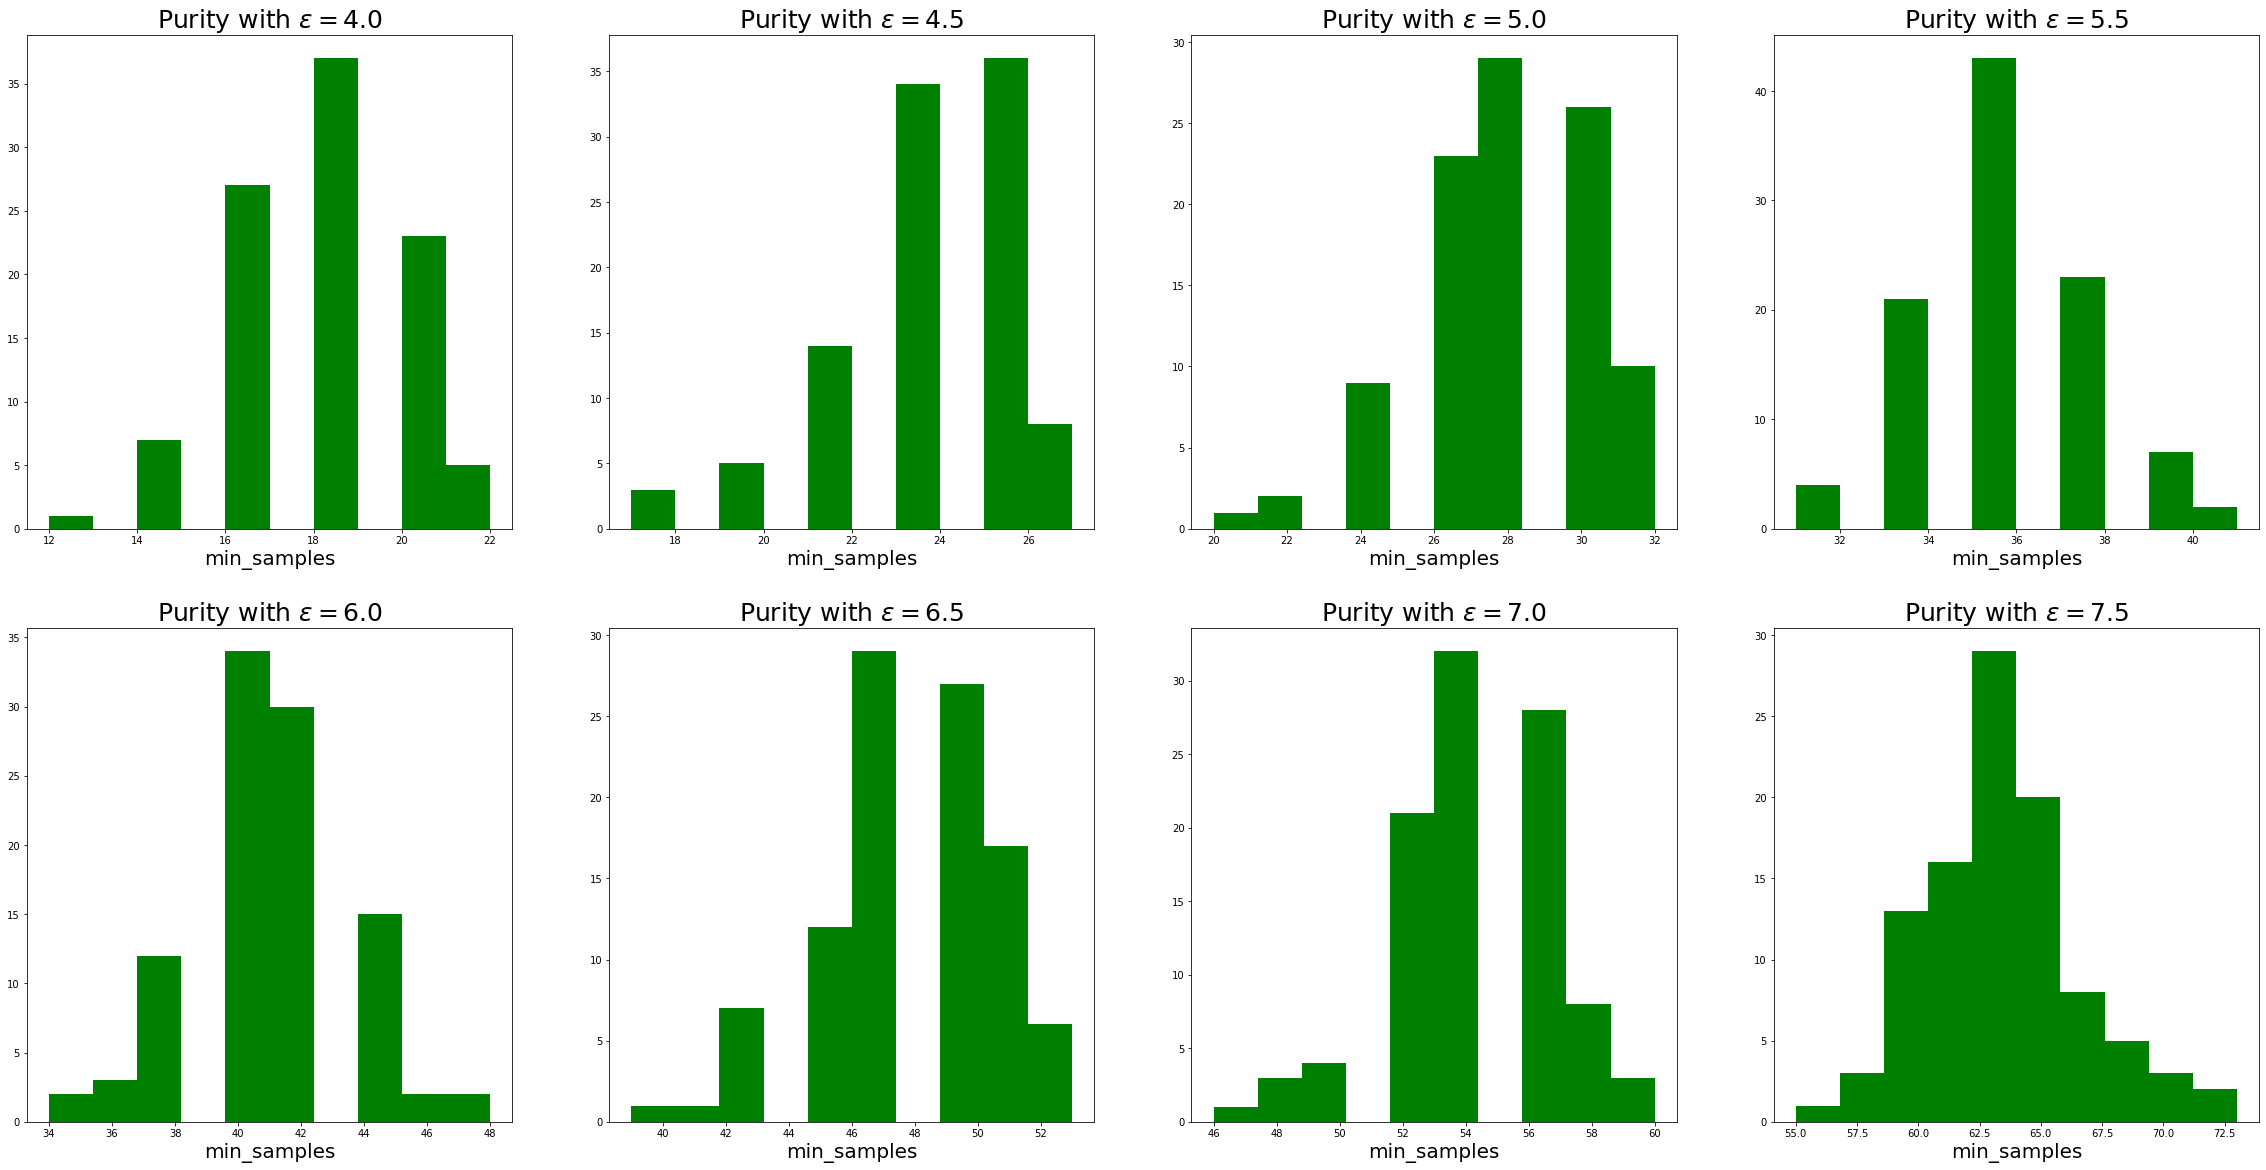

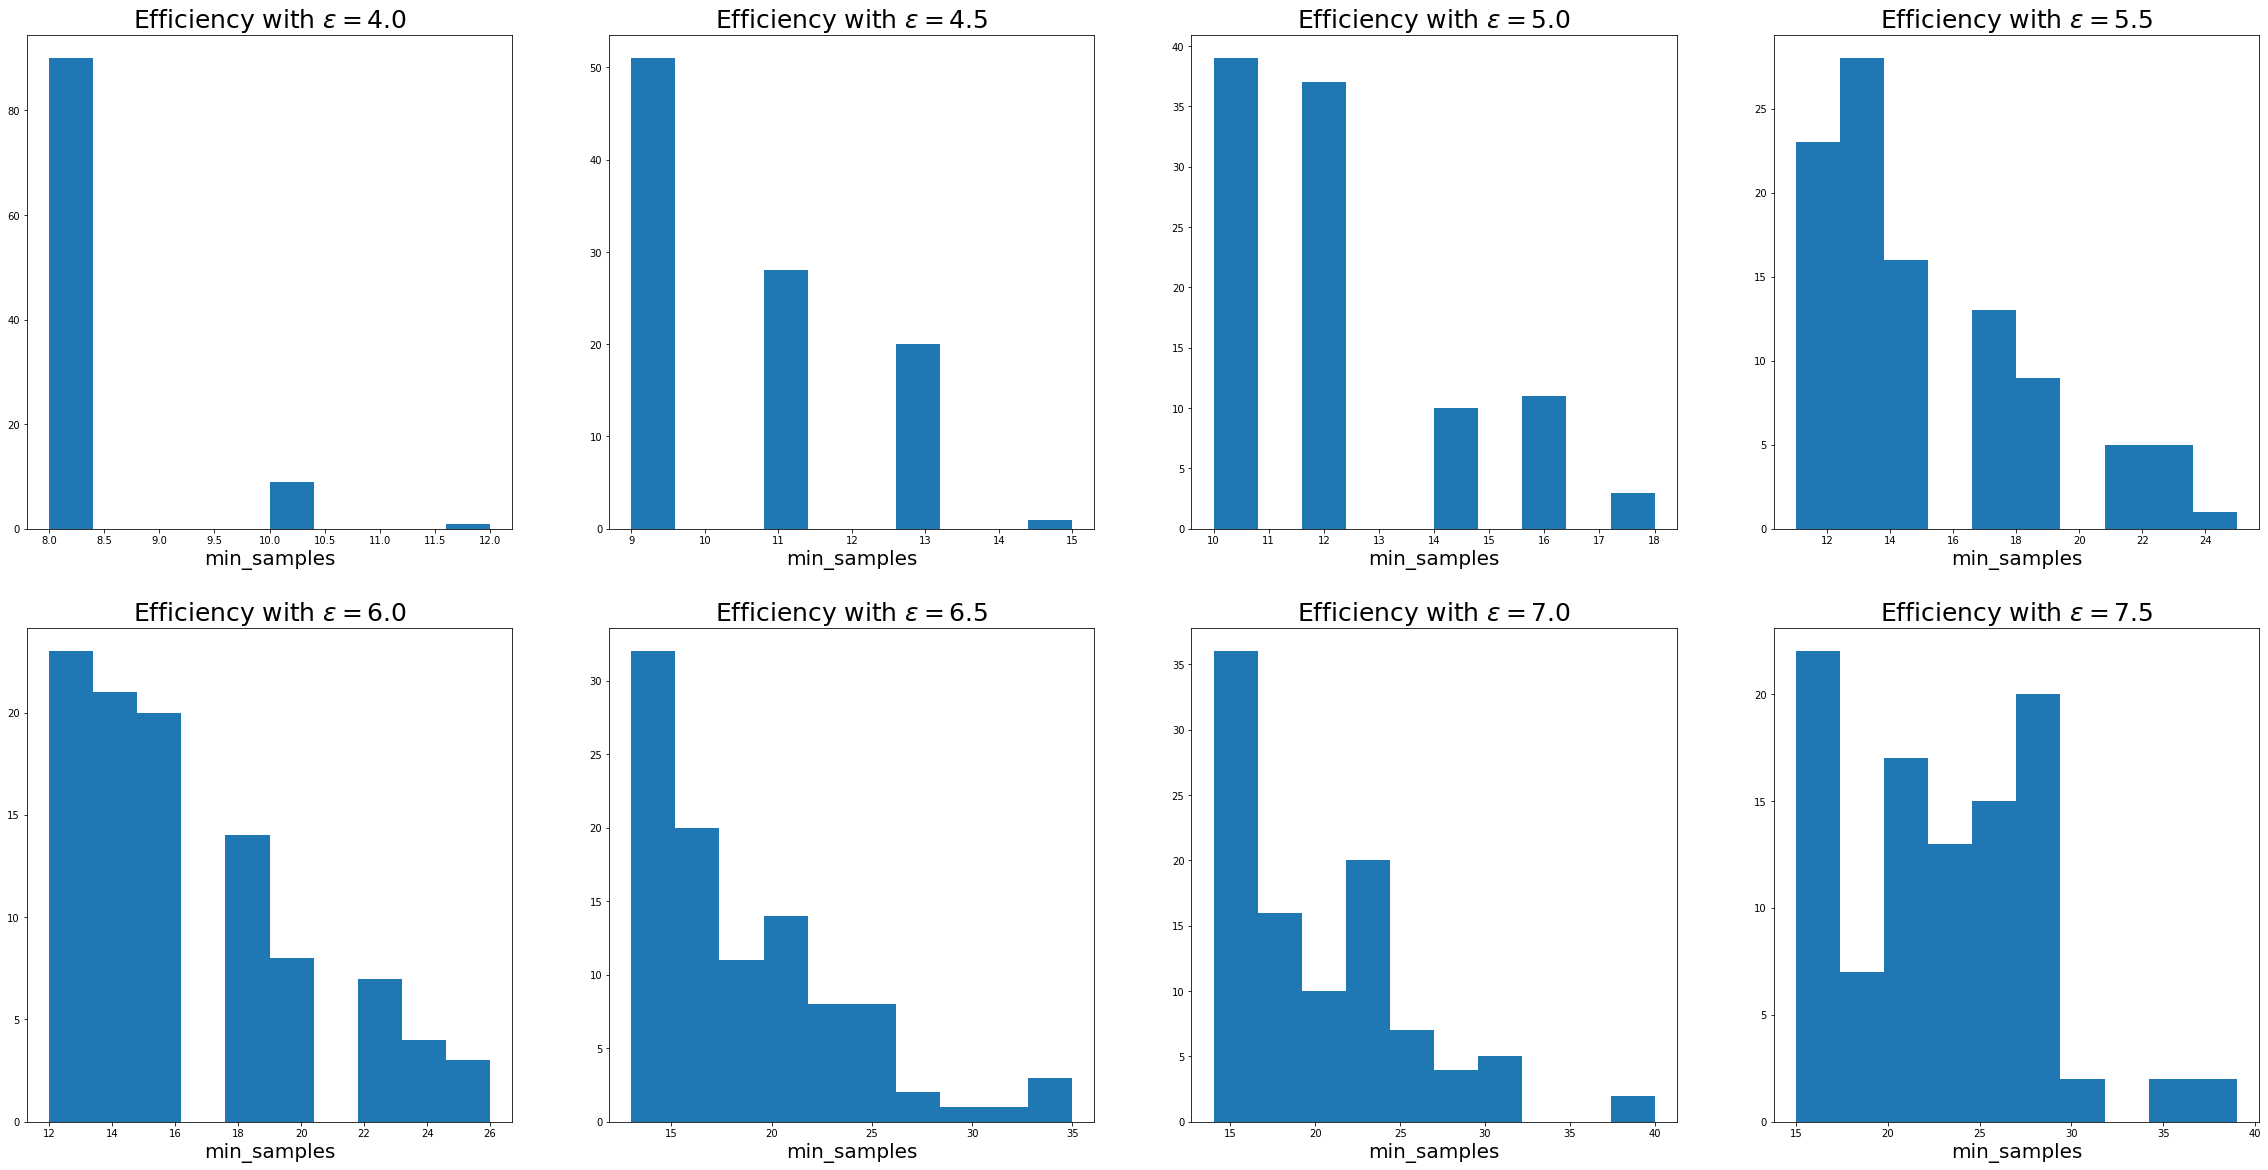

In [0]:
hist_dataframe_p = pd.DataFrame(hist_purity)
hist_dataframe_e = pd.DataFrame(hist_efficiency)

#Purity
epsilon = 4.0

for i in range(4):

  plt.subplot(2,4,i+1)
  a = hist_dataframe_p[i].to_numpy()
  plt.xlabel('min_samples',fontsize=20)
  plt.title('Purity with $\epsilon = %.1f$' %epsilon,fontsize=25)
  plt.hist(a, color='green')
  epsilon+=0.5

for i in range(4):

  plt.subplot(2,4,i+5)
  a = hist_dataframe_p[i+4].to_numpy()
  plt.xlabel('min_samples',fontsize=20)
  plt.title('Purity with $\epsilon = %.1f$' %epsilon,fontsize=25)
  plt.hist(a, color='green')
  epsilon+=0.5

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(40, 20)

plt.show()

#Efficiency
epsilon = 4.0

for i in range(4):

  plt.subplot(2,4,i+1)
  a = hist_dataframe_e[i].to_numpy()
  plt.xlabel('min_samples',fontsize=20)
  plt.title('Efficiency with $\epsilon = %.1f$' %epsilon,fontsize=25)
  plt.hist(a)
  epsilon+=0.5

for i in range(4):

  plt.subplot(2,4,i+5)
  a = hist_dataframe_e[i+4].to_numpy()
  plt.xlabel('min_samples',fontsize=20)
  plt.title('Efficiency with $\epsilon = %.1f$' %epsilon,fontsize=25)
  plt.hist(a)
  epsilon+=0.5

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(40, 20)

plt.show()

# GRAFICO PURITY VS DETECTION EFFICIENCY VS $N_{cluster}$

[0.9576442912391345, 0.9651023005801843, 0.9558141930128341, 0.972657326899738, 0.972764213271077, 0.97902496862197, 0.9572164096916299, 0.9704017857142857, 0.9691343862890123, 0.9740372637128352, 0.9561631335026197, 0.9765433372624324, 0.9781521443055597, 0.97902496862197, 0.9572164096916299, 0.9704017857142857, 0.9691343862890123, 0.9740372637128352, 0.9561631335026197, 0.9765433372624324, 0.9567979776388931, 0.9660041352886367, 0.94471640969163]
[0.5354166666666667, 0.5151041666666667, 0.590625, 0.521875, 0.47239583333333335, 0.409375, 0.4890625, 0.44583333333333336, 0.5109375, 0.459375, 0.5119791666666667, 0.44166666666666665, 0.4322916666666667, 0.4166666666666667, 0.49635416666666665, 0.453125, 0.5182291666666666, 0.4666666666666667, 0.5192708333333333, 0.44895833333333335, 0.5442708333333334, 0.5286458333333334, 0.6083333333333333]
[0.875, 0.875, 1.125, 0.875, 0.75, 0.75, 0.875, 0.625, 1, 0.875, 1.25, 0.625, 0.5, 0.625, 0.875, 0.625, 1, 0.875, 1.25, 0.625, 0.625, 0.75, 1]


<function matplotlib.pyplot.show>

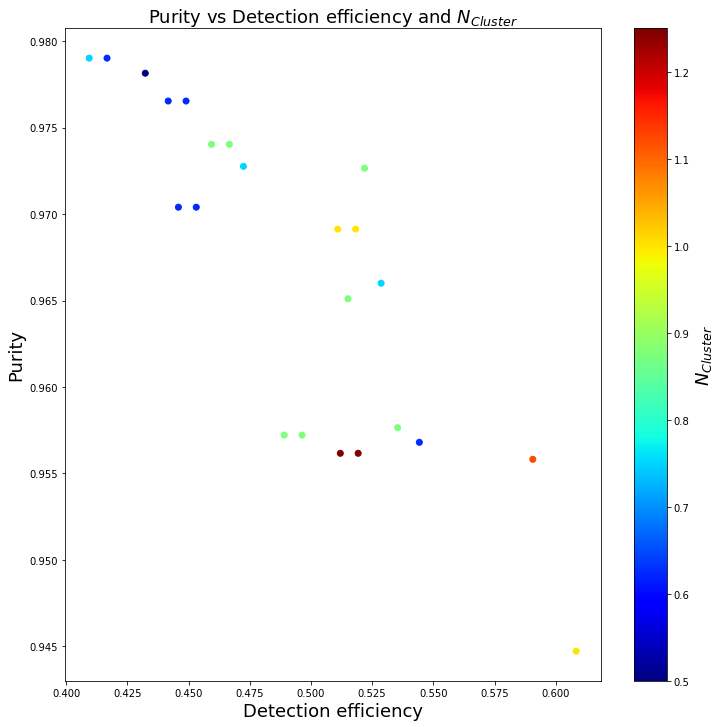

In [0]:
import statistics as st

n_eps = int((max_eps - min_eps)/step_eps)
end_loop = int(len(list_p)/n_eps)
mean_p = []
mean_e = []
mean_n = []

for i in range(0, end_loop, 1):

  temp_p = []
  temp_e = []
  temp_n = []

  for j in range(0, n_eps, 1):

    ind = i + j*n_eps
    temp_p.append(list_p[ind])
    temp_e.append(list_e[ind])
    temp_n.append(list_n[ind])
    #print(plot_p)
    #print(ind)

  mean_p.append(st.mean(temp_p))
  mean_e.append(st.mean(temp_e))
  mean_n.append(st.mean(temp_n))

print(mean_p)
print(mean_e)
print(mean_n)

fig = plt.figure(figsize=(12,12))
plt.scatter(mean_e,mean_p,c=mean_n,cmap='jet')
ax = plt.colorbar()
ax.set_label('$N_{Cluster}$',fontsize=18)
plt.title('Purity vs Detection efficiency and $N_{Cluster}$',fontsize=18)
plt.xlabel('Detection efficiency',fontsize=18)
plt.ylabel('Purity',fontsize=18)
plt.show

In [0]:
import statistics as st

purity_dataframe = pd.DataFrame(purity_highest)
efficiency_dataframe = pd.DataFrame(efficiency_highest)

purity_mean = []
purity_std = []

efficiency_mean = []
efficiency_std = []

for i in range(8):

  a = purity_dataframe[i].to_numpy()
  b = efficiency_dataframe[i].to_numpy()

  mean_p = st.mean(a)
  mean_e = st.mean(b)

  std_p = st.stdev(a)
  std_e = st.stdev(b)

  purity_mean.append(mean_p)
  purity_std.append(std_p)

  efficiency_mean.append(mean_e)
  efficiency_std.append(std_e)

print(purity_mean)
print(purity_std)
print(efficiency_mean)
print(efficiency_std)

[0.9974220032840723, 0.9904619026778915, 0.9922152414265198, 0.9962848297213622, 0.9955530270345192, 0.9961714599743543, 0.9990825688073395, 0.9980504389740058]
[0.005474575692347038, 0.013979169541138496, 0.010702547809991742, 0.007847360645398779, 0.007942353514819322, 0.006649482607714955, 0.0029011721652920735, 0.0043451667722095594]
[0.9764198961762094, 0.9886478088336157, 0.9923524758621642, 0.9967683047394436, 0.9967683047394436, 0.9992046173308033, 0.9992046173308033, 0.9992046173308033]
[0.011431820121132958, 0.005377651602310132, 0.006128303525504416, 0.0025475013864858396, 0.0025475013864858396, 0.0016770168519022821, 0.0016770168519022821, 0.0016770168519022821]
